# IEOR 4571 - Personalization - Final Project

#### Team members: 
Name, UNI/email, Github ID
* Megala Kannan, msk2245@columbia.edu, thisismeg
* Hojin Lee, hl3328@columbia.edu, hjlee9295
* Jung Ah Shin, js5569@columbia.edu, juliajungahshin
* Tiffany Zhu, tz2196@columbia.edu, tlzhu19


# TOC:
* [1. Introduction](#1)
* [2. Data Exploration](#2)
* [3. Modeling](#3)
    * [3.1 Baseline Model: Learned Bias](#3-1)
        * [3.1.1 Accuracy of Learned Bias Model](#3-1-1)
        * [3.1.2 Coverage of Learned Bias Model](#3-1-2)
    * [3.2 Baseline Model: Collaborative Filtering (ALS)](#3-2)
        * [3.2.1 Tuning Hyperparameters](#3-2-1)
        * [3.2.2 Accuracy of ALS Model](#3-2-2)
        * [3.2.3 Coverage of ALS Model](#3-2-3)
    * [3.3 SVD++](#3-3)
    * [3.4 Wide and Deep Model](#3-4)
        * [3.4.1 Feature Selection](#3-4-1)
        * [3.4.2 Modeling](#3-4-2)
        * [3.4.3 Accuracy](#3-4-3)
        * [3.4.4 Coverage](#3-4-4)     
* [4. Evaluation](#4)
    * [4.1 Accuracy](#4-1)
    * [4.2 Coverage](#4-2)
* [5. Conclusion](#5)


# 1. Introduction <a class="anchor" id="1"></a>

Yelp is a crowd-sourced review platform where users interact with businesses and other users through writing reviews and discovering new businesses.

To make this platform more effective, we leverage various attributes of users, businesses, and reviews to provide better business recommendation for users. 

Our initial goal is to predict the last rating (final review) for each active user, where active users are those that gave 5 or more reviews. While aiming towards minimizing the difference between the actual rating and our prediction, we also want our recommendation model to provide diverse recommendations so that many users have an opportunity to explore new contents.

In line with our objectives, we decided to explore several recommendation algorithms to gain a better understanding of the advantages and disadvantages each model provides.
We chose SVD++, Non-negative Matrix Factorization(NMF), and Wide and Deep algorithms.

We compare the aforementioned models with two baseline models, which are user and item bias baseline, and a vanilla Matrix Factorization model.

To evaluate and compare the accuracy of our models, we used the following metrics: 
* RMSE 

These values would indicate how well our models perform compared to the baseline models.

To evaluate the quality and diversity of our models, the following metrics are used:
* Coverage
* … 

Detailed description of each process is provided below.

# 2. Data Exploration <a class="anchor" id="2"></a>

In [110]:
import pandas as pd
import json
from tqdm import tqdm

import numpy as np # linear algebra
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

import itertools
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

In [111]:
def convert_json_to_df(path, file_name, column_names):
    '''
    converts the json file into a pandas dataframe
    path: string of path
    file_name: string of json file name
    column_names: the names of the json file attributes (used as the dataframe column names)
    returns: dataframe
    '''
    line_count = len(open(path + file_name).readlines())    
    columns_dict = {name: [] for name in column_names}

    with open(path + file_name) as f:
        for line in tqdm(f, total=line_count):
            blob = json.loads(line)
            
            for key in column_names:
                columns_dict[key].append(blob[key])
    
    return pd.DataFrame(columns_dict)

In [112]:
path = "/Users/tiffanyzhu/Downloads/yelp_dataset/"
file_name = "review.json"

In [4]:
# review.json
ratings = convert_json_to_df(path, file_name, ['user_id', 'business_id', 'stars', 'date'])

user_counts = ratings["user_id"].value_counts()
active_users = user_counts.loc[user_counts >= 5].index.tolist()

100%|██████████| 6685900/6685900 [01:21<00:00, 82502.81it/s]


In [5]:
len(active_users)

286130

In [6]:
ratings.rename(columns={'stars': 'rating'}, inplace=True)
ratings.head()

,user_id,business_id,rating,date
0,hG7b0MtEbXx5QzbzE6C_VA,ujmEBvifdJM6h6RLv4wQIg,1.0,2013-05-07 04:34:36
1,yXQM5uF2jS6es16SJzNHfg,NZnhc2sEQy3RmzKTZnqtwQ,5.0,2017-01-14 21:30:33
2,n6-Gk65cPZL6Uz8qRm3NYw,WTqjgwHlXbSFevF32_DJVw,5.0,2016-11-09 20:09:03
3,dacAIZ6fTM6mqwW5uxkskg,ikCg8xy5JIg_NGPx-MSIDA,5.0,2018-01-09 20:56:38
4,ssoyf2_x0EQMed6fgHeMyQ,b1b1eb3uo-w561D0ZfCEiQ,1.0,2018-01-30 23:07:38


In [6]:
# can do the same for business.json, user.json, tip.json 
# for metadata info see https://www.yelp.com/dataset/documentation/main

In [99]:
# business.json
# todo: how to add 'attributes'?
'''
"attributes": {
        "RestaurantsTakeOut": true,
        "BusinessParking": {
            "garage": false,
            "street": true,
            "validated": false,
            "lot": false,
            "valet": false
        },
'''

businesses = convert_json_to_df(path, 'business.json', ['business_id', 'city', 'state', 'stars', 
                                                        'review_count', 'is_open', 'attributes', 
                                                        'categories', 'hours', 'latitude', 'longitude', 'name'])

100%|██████████| 192609/192609 [00:04<00:00, 41327.48it/s]


In [100]:
businesses.head()

,business_id,city,state,stars,review_count,is_open,attributes,categories,hours,latitude,longitude,name
0,1SWheh84yJXfytovILXOAQ,Phoenix,AZ,3.0,5,0,{'GoodForKids': 'False'},"Golf, Active Life",None,33.522143,-112.018481,Arizona Biltmore Golf Club
1,QXAEGFB4oINsVuTFxEYKFQ,Mississauga,ON,2.5,128,1,"{'RestaurantsReservations': 'True', 'GoodForMe...","Specialty Food, Restaurants, Dim Sum, Imported...","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",43.605499,-79.652289,Emerald Chinese Restaurant
2,gnKjwL_1w79qoiV3IC_xQQ,Charlotte,NC,4.0,170,1,"{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...","Sushi Bars, Restaurants, Japanese","{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",35.092564,-80.859132,Musashi Japanese Restaurant
3,xvX2CttrVhyG2z1dFg_0xw,Goodyear,AZ,5.0,3,1,None,"Insurance, Financial Services","{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",33.455613,-112.395596,Farmers Insurance - Paul Lorenz
4,HhyxOkGAM07SRYtlQ4wMFQ,Charlotte,NC,4.0,4,1,"{'BusinessAcceptsBitcoin': 'False', 'ByAppoint...","Plumbing, Shopping, Local Services, Home Servi...","{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ...",35.190012,-80.887223,Queen City Plumbing


In [13]:
# user.json
users = convert_json_to_df(path, 'user.json', ['user_id', 'review_count', 'friends', 'useful', 
                                               'funny', 'cool', 'fans', 'elite', 'average_stars', 
                                               'compliment_hot', 'compliment_more', 'compliment_profile',
                                               'compliment_cute', 'compliment_list', 'compliment_note',
                                               'compliment_plain', 'compliment_cool', 'compliment_funny',
                                               'compliment_writer', 'compliment_photos'
                                              ])

100%|██████████| 1637138/1637138 [00:35<00:00, 46222.22it/s]


In [20]:
users.head()

,user_id,review_count,friends,useful,funny,cool,fans,elite,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,l6BmjZMeQD3rDxWUbiAiow,95,"c78V-rj8NQcQjOI8KP3UEA, alRMgPcngYSCJ5naFRBz5g...",84,17,25,5,"2015,2016,2017",4.03,2,0,0,0,0,1,1,1,1,2,0
1,4XChL029mKr5hydo79Ljxg,33,"kEBTgDvFX754S68FllfCaA, aB2DynOxNOJK9st2ZeGTPg...",48,22,16,4,,3.63,1,0,0,0,0,0,0,1,1,0,0
2,bc8C_eETBWL0olvFSJJd0w,16,"4N-HU_T32hLENLntsNKNBg, pSY2vwWLgWfGVAAiKQzMng...",28,8,10,0,,3.71,0,0,0,0,0,1,0,0,0,0,0
3,dD0gZpBctWGdWo9WlGuhlA,17,"RZ6wS38wnlXyj-OOdTzBxA, l5jxZh1KsgI8rMunm-GN6A...",30,4,14,5,,4.85,1,0,0,0,0,0,2,0,0,1,0
4,MM4RJAeH6yuaN8oZDSt0RA,361,"mbwrZ-RS76V1HoJ0bF_Geg, g64lOV39xSLRZO0aQQ6DeQ...",1114,279,665,39,"2015,2016,2017,2018",4.08,28,1,0,0,1,16,57,80,80,25,5


In [14]:
# tip.json
tips =  convert_json_to_df(path, 'tip.json', ['text', 'date', 'compliment_count', 'business_id', 'user_id'])

100%|██████████| 1223094/1223094 [00:09<00:00, 122404.61it/s]


In [29]:
photos = convert_json_to_df(path, 'photo.json', ['photo_id', 'business_id'])

100%|██████████| 200000/200000 [00:01<00:00, 194952.47it/s]


Exploratory analysis of our data shows some interesting patterns.
By looking at the distribution of ratings, the majority of the ratings are concentrated in the upper-half, indicating that most users gave 3.5 to 5.0 in their reviews.  
It shows that most ratings are positive, where as only a small amount of ratings were negative ( rating <  3.0).  
We can hypothesize from this evaluation that since our models will be trained primarily by positive ratings,  it might perform better at predicting ratings for businesses they are likely to enjoy than those they are less likely to enjoy. 

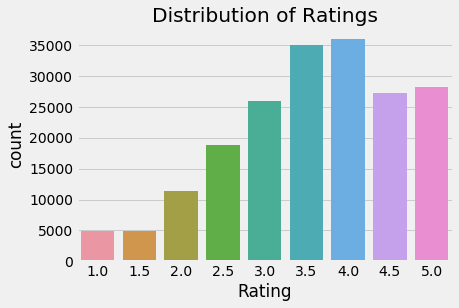

In [368]:
chart = sns.countplot(x='stars',data=businesses)
var = chart.set(xlabel='Rating', title='Distribution of Ratings')

To see which specific businesses might have received the highest number of ratings, Starbucks overall received the most number of ratings,  followed by McDonald’s and Hash House A Go Go. We could observe that franchise businesses tend to have many reviews due to having branches in various locations.

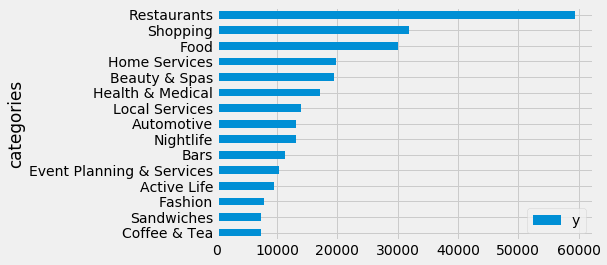

In [97]:
catList = []
businesses['categories'].fillna(value='',inplace=True)
businesses['cat'] = businesses['categories'].apply(lambda x: x.split(','))
catList.extend(businesses['cat'])
merged = [x.strip() for x in list(itertools.chain(*catList))]

mostCommon = Counter(merged).most_common(15)
mostCommonKeys = [x for x in list(itertools.chain(*mostCommon)) if type(x) != int]
mostCommonValues = [x for x in list(itertools.chain(*mostCommon)) if type(x) == int]

df = pd.DataFrame({'y': mostCommonValues, 'categories': mostCommonKeys})
ax = df.plot.barh(x='categories', y='y')
ax.invert_yaxis()

In addition, we also looked at which categories the businesses belong in. Our analysis indicate 
that the top-5 most common categories are restaurants, shopping, food, home services, and beauty & spas. Furthermore, the top-5 most common categories cover approximately 71% of the data, hence these categories are used as features for our Wide and Deep model.

In [193]:
topKBusiness = [5,10,20]

for n in topKBusiness:
    catList = []
    businesses['categories'].fillna(value='',inplace=True)
    businesses['cat'] = businesses['categories'].apply(lambda x: x.split(','))
    catList.extend(businesses['cat'])
    merged = [x.strip() for x in list(itertools.chain(*catList))]
    mostCommon = Counter(merged).most_common(n)
    mostCommonKeys = [x for x in list(itertools.chain(*mostCommon)) if type(x) != int]
    mostCommonValues = [x for x in list(itertools.chain(*mostCommon)) if type(x) == int]

    colName = 'Top' + str(n)
    businesses[colName] = businesses['cat'].apply(lambda categories: 1 if bool(set([y.strip() for y in categories]).intersection(mostCommonKeys)) else 0)   
    print('business covered percentage when k =', n, ":", businesses[colName].mean())

business covered percentage when k = 5 : 0.7069243908643936
business covered percentage when k = 10 : 0.8770670114065282
business covered percentage when k = 20 : 0.9306418703175864


The distribution of ratings of active users indicate that while there are a small number of users who have reviewed around 4000 times (Max: 4129), the vast majority of the users have reviewed around 5 times.

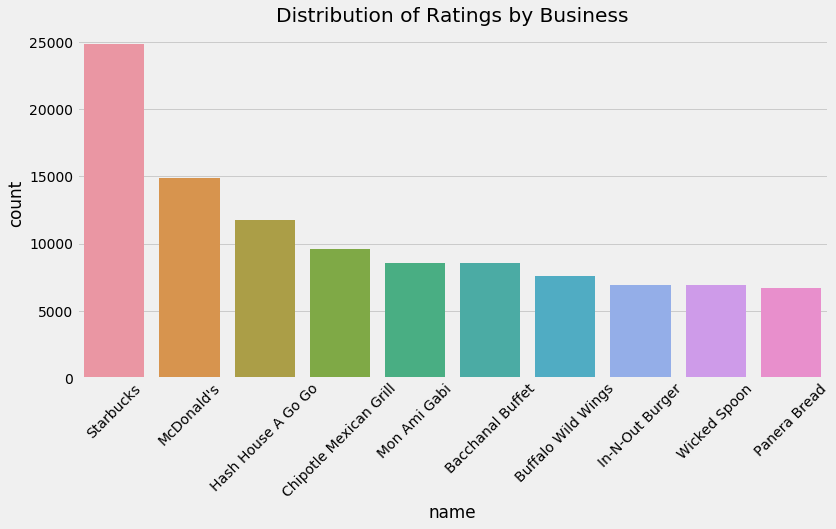

In [104]:
df = ratings.merge(businesses[['business_id', 'name']], on='business_id')
plt.figure(figsize=(12,6))

chart = sns.countplot(x='name',data=df, order=pd.value_counts(df['name']).iloc[:10].index)
chart.set(title='Distribution of Ratings by Business')
var = chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

In [246]:
user_counts[user_counts.values >= 5].describe()

count    286130.000000
mean         15.860874
std          32.607378
min           5.000000
25%           6.000000
50%           8.000000
75%          15.000000
max        4129.000000
Name: user_id, dtype: float64

[Text(0.5, 0, 'Ratings'),
 Text(0.5, 1.0, 'Distribution of Ratings of Active Users')]

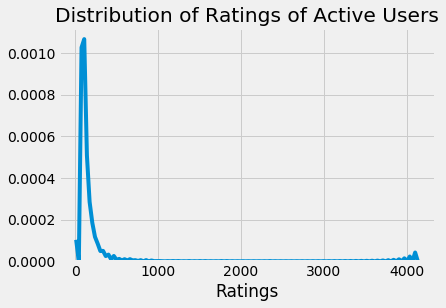

In [248]:
chart = sns.distplot(user_counts.values[user_counts.values > 15], norm_hist=True, hist=False, bins=5)
chart.set(title='Distribution of Ratings of Active Users', xlabel='Ratings')

# 3. Modeling <a class="anchor" id="3"></a>

## 3.0 Sampling Data

By identifying and filtering the users who gave 5 or more reviews, there are 286,130 active users and about 4.5 million ratings.

Since we wanted to evaluate the performance on several models, we first sampled the active user data where there are 1000, 10,000, and 50,000 users (where 50,000 users account for approximately 17.5% of the entire data).

For this given dataset, we wanted to sample by users to ensure that our sample dataset would contain an entire user-business interaction history of the sampled users. That way, it would align with our goal of predicting the last rating for each active user based on the entire user-business interaction history.

Furthermore, since users’ preference towards restaurants could gradually change over time, we believe that it would be reasonable to split our train and test data so that the train data would contain the earlier reviews, and the test data would consist of the latter reviews given by the users. That way, while we are supposedly predicting “future” reviews,  it is also consistent with our objective of predicting the final star rating (by date) given by the user. 

We also analyzed the categories for each business. Based on this analysis, we decided to use the top-5 categories to feed into our model. This is because they account for approximately 70% of the businesses in our data.


In [185]:
active_user_only_ratings_df = ratings[ratings['user_id'].isin(active_users)]
len(active_user_only_ratings_df)

4538272

In [186]:
len(active_user_only_ratings_df['user_id'].unique())

286130

In [199]:
import datetime as dt

def get_sample_size_n(active_user_only_ratings_df, n): 
    sample_size = [n]

    for s in sample_size:
        sampleUID = active_user_only_ratings_df['user_id'].unique()[np.random.randint(active_user_only_ratings_df['user_id'].unique().shape[0], size=s)]
        active_user_only_ratings_df_sample = active_user_only_ratings_df[active_user_only_ratings_df['user_id'].isin(sampleUID)]
    
    active_user_only_ratings_df_sample['date'] = pd.to_datetime(active_user_only_ratings_df_sample['date'])

    # take 80% of reviews for each user sampled
    training_data = active_user_only_ratings_df_sample.sort_values(by=['user_id', 'date']).groupby('user_id').apply(lambda x: x[:round(len(x)*.8)]).reset_index(drop=True)

    # take 20% of reviews for each user sampled
    testing_data = active_user_only_ratings_df_sample.sort_values(by=['user_id', 'date']).groupby('user_id').apply(lambda x: x[round(len(x)*.8):]).reset_index(drop=True)
    
    return active_user_only_ratings_df_sample, training_data, testing_data

In [200]:
def print_df_info(n, total_df, training_df, testing_df):
    print('Total Number of Ratings: ', len(total_df))
    print('Total Number of Users: ', n)
    print("Training Size: ", len(training_df))
    print("Testing Size: ", len(testing_df))

In [204]:
sample_sizes = [1000, 10000, 50000]
active_user_only_ratings_df_sample, training_data, testing_data = get_sample_size_n(active_user_only_ratings_df, sample_sizes[0])
print_df_info(sample_sizes[0], active_user_only_ratings_df_sample, training_data, testing_data)

Total Number of Ratings:  1612
Total Number of Users:  1000
Training Size:  1289
Testing Size:  323


In [207]:
active_user_only_ratings_df_sample2, training_data2, testing_data2 = get_sample_size_n(active_user_only_ratings_df, sample_sizes[1])
print_df_info(sample_sizes[1], active_user_only_ratings_df_sample2, training_data2, testing_data2)

Total Number of Ratings:  152113
Total Number of Users:  10000
Training Size:  122070
Testing Size:  30043


In [208]:
active_user_only_ratings_df_sample3, training_data3, testing_data3 = get_sample_size_n(active_user_only_ratings_df, sample_sizes[2])
print_df_info(sample_sizes[2], active_user_only_ratings_df_sample3, training_data3, testing_data3)

Total Number of Ratings:  739984
Total Number of Users:  50000
Training Size:  593536
Testing Size:  146448


## 3.1 Baseline Model: Learned Bias <a class="anchor" id="3-1"></a>

In [153]:
def find_average_user_ratings(ratings_df):
    ratings_series = ratings_df.groupby('user_id')['rating'].mean()
    return pd.DataFrame({'user_id':ratings_series.index, 'rating':ratings_series.values})

# average_user_ratings = find_average_user_ratings(X_data)

In [154]:
def find_average_business_ratings(ratings_df):    
    ratings_series = ratings_df.groupby('business_id')['rating'].mean()
    return pd.DataFrame({'business_id':ratings_series.index, 'rating':ratings_series.values})

# average_business_ratings = find_average_business_ratings(X_data)

In [174]:
# ratings_df - for each user need to remove its last review

def predict_learned_bias(actual_ratings, average_user_ratings, average_business_ratings):

    avg_business_ratings_dict = dict(zip(average_business_ratings.business_id, average_business_ratings.rating))
    
    def find_business_avg(row):
        #todo: what if business we are trying to predict was not seen? give it 3 (out of 5)?
        return avg_business_ratings_dict.get(row['business_id'], 4)  
    
    avg_business_ratings = actual_ratings.apply(find_business_avg, axis=1)
    print('avg_business_ratings created!')
    
    # we are assuming that the order is the same in each avg_business_ratings and average_user_ratings
    predicted_rating = (avg_business_ratings + average_user_ratings['rating']) / 2
    print('predicted_rating created!')
    
    actual_ratings['predicted_rating'] = predicted_rating.values
    
    return actual_ratings
    
# baseline_line_predictions_test = predict_learned_bias(y_data, average_user_ratings, average_business_ratings)
# baseline_line_predictions_train = predict_learned_bias(X_data, average_user_ratings, average_business_ratings)

avg_business_ratings created!
predicted_rating created!
avg_business_ratings created!
predicted_rating created!


In [139]:
def calculate_catalog_coverage(ratingsDict, N, k=3, pred_col_name='predicted_rating'):
    '''
    k: top k businesses
    N: total number of businesses
    '''
    
    recList = []
    for keys in ratingsDict.keys():
        
        if k >= len(ratingsDict[keys]):
            for row in ratingsDict[keys]:
                recList.append(row['business_id'])
        else:
            for index, item in enumerate(sorted(ratingsDict[keys], key=lambda x: -x[pred_col_name])):
                if index+1 <= k:
                    recList.append(item['business_id'])
                else:
                    pass

    recommended_set = set(recList)

    coverage = (len(recommended_set) / N) * 100
    print('Catalog Coverage: {}%'.format(coverage))
    return coverage

In [195]:
def run_baseline_model(df):
    X_data = df.sort_values(by=['user_id', 'date']).groupby('user_id').apply(lambda x: x[:-1]).reset_index(drop=True)
    y_data = df.sort_values(by=['user_id', 'date']).groupby('user_id').apply(lambda x: x[-1:]).reset_index(drop=True)
    
    average_user_ratings = find_average_user_ratings(X_data)
    average_business_ratings = find_average_business_ratings(X_data)
    
    baseline_line_predictions_test = predict_learned_bias(y_data, average_user_ratings, average_business_ratings)
    baseline_line_predictions_train = predict_learned_bias(X_data, average_user_ratings, average_business_ratings)
    
    N = len(baseline_line_predictions_test)
    baseline_rmse_test = np.sum(np.sqrt(((baseline_line_predictions_test['predicted_rating'] - baseline_line_predictions_test['rating']) / N) ** 2))
    
    baseline_line_predictions_dict = dict(baseline_line_predictions_train.set_index('user_id').groupby(level = 0).apply(lambda x : x.to_dict(orient= 'records')))
    N = len(baseline_line_predictions_train['business_id'].unique())
    coverage = calculate_catalog_coverage(baseline_line_predictions_dict, N, k=5)

    return baseline_rmse_test, coverage

In [196]:
rmse, coverage = run_baseline_model(active_user_only_ratings_df_sample)

avg_business_ratings created!
predicted_rating created!
avg_business_ratings created!
predicted_rating created!
Catalog Coverage: 40.49955396966994%


In [197]:
rmse, coverage 

(1.1530508932251118, 40.49955396966994)

In [209]:
rmse2, coverage2 = run_baseline_model(active_user_only_ratings_df_sample2)

avg_business_ratings created!
predicted_rating created!
avg_business_ratings created!
predicted_rating created!
Catalog Coverage: 48.15294181092595%


In [210]:
rmse2, coverage2

(1.1409001004201271, 48.15294181092595)

In [211]:
rmse3, coverage3 = run_baseline_model(active_user_only_ratings_df_sample3)

avg_business_ratings created!
predicted_rating created!
avg_business_ratings created!
predicted_rating created!
Catalog Coverage: 58.35646295571032%


In [212]:
rmse3, coverage3

(1.1135921457245015, 58.35646295571032)

### 3.1.1 Accuracy of Learned Bias Model<a class="anchor" id="3-1-1"></a>

We look at RMSE as an measure of accuracy.

In [366]:
baseline_rmses = [rmse, rmse2, rmse3]
baseline_rmses

[2.6811320848264084, 1.1409001004201271, 1.1135921457245015]

### 3.1.2 Coverage of Learned Bias Model<a class="anchor" id="3-1-2"></a>

We look at catalog coverage.

In [367]:
baseline_coverages = [coverage, coverage2, coverage3]
baseline_coverages

[40.49955396966994, 48.15294181092595, 58.35646295571032]

### 3.2 Baseline Model: Collaborative Filtering (ALS)  <a class="anchor" id="3-2"></a>

In [327]:
from pyspark.mllib.recommendation import ALS
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.ml.tuning import (CrossValidator, ParamGridBuilder)

import pyspark.sql.functions as sql_func
from pyspark.sql.types import *
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.mllib.evaluation import RegressionMetrics, RankingMetrics
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.sql.functions import col

# Load ratings data into PySpark dataframe
data_schema = StructType([
    StructField('numeric_user_id', IntegerType(), False),
    StructField('numeric_business_id', IntegerType(), False),
    StructField('rating',FloatType(), False)])

#Spark Session
spark =SparkSession.builder.appName('ALS').getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)


In [331]:
all_sample_dfs = [active_user_only_ratings_df_sample, active_user_only_ratings_df_sample2, active_user_only_ratings_df_sample3]
all_training_dfs = [training_data, training_data2, training_data3]
all_testing_dfs = [testing_data, testing_data2, testing_data3]


for df in [all_training_dfs, all_testing_dfs]:
    for train in df:
        numeric_user_id_dict = {key: value + 1 for value, key in enumerate(train['user_id'].unique())}
        numeric_business_id_dict = {key: value + 1 for value, key in enumerate(train['business_id'].unique())}

        train['numeric_user_id'] = train['user_id'].apply(lambda u: numeric_user_id_dict[u])
        train['numeric_business_id'] = train['business_id'].apply(lambda b: numeric_business_id_dict[b])

In [332]:
# Create Spark DF from Pandas DF
all_sample_spark_dfs_train = []
all_sample_spark_dfs_test = []

for sample_df in all_training_dfs:
    new_sample_df = sample_df[['numeric_user_id', 'numeric_business_id', 'rating']]
    spark_sample_df = spark.createDataFrame(new_sample_df, schema=data_schema)
    all_sample_spark_dfs_train.append(spark_sample_df)

for sample_df in all_testing_dfs:
    new_sample_df = sample_df[['numeric_user_id', 'numeric_business_id', 'rating']]
    spark_sample_df = spark.createDataFrame(new_sample_df, schema=data_schema)
    all_sample_spark_dfs_test.append(spark_sample_df)

In [346]:
def plot_rmse_vs_param(cvModels, param_list, xlabel):
    plt.figure(figsize=(10, 6))
    for cvModel in cvModels: 
        plt.plot(param_list, cvModel.avgMetrics, marker='o')

    plt.xlabel(xlabel)
    plt.ylabel('RMSE')
    plt.title('RMSE vs {} by Number of Active Users'.format(xlabel))
    plt.legend(['{} Active Users'.format(n) for n in sample_sizes])
    plt.grid(True)
    plt.show()

### 3.2.1 Tuning Hyperparameters  <a class="anchor" id="3-2-1"></a>

**Regularization Parameter**

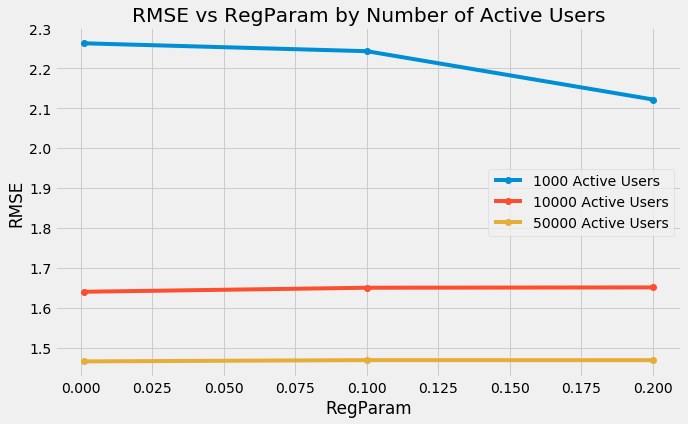

In [353]:
plot_rmse_vs_param(cvs, reg_list, 'RegParam')

In [354]:
best_reg = 0.2

**Rank**

In [358]:
import time

als = ALS(regParam=best_reg, maxIter=5, userCol="numeric_user_id", itemCol="numeric_business_id", ratingCol="rating",
          coldStartStrategy="drop", nonnegative= True)

rank_list = [5, 10, 20]
paramGrid = ParamGridBuilder().addGrid(als.rank, rank_list).build()
crossval_rank = CrossValidator(estimator=als,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(metricName="rmse",
                                                        labelCol="rating"),
                          numFolds=3)

cv_ranks = []
for i in range(3):
    start = time.time()
    cv_rank = crossval_rank.fit(all_sample_spark_dfs_train[i])
    cv_ranks.append(cv_rank)
    end = time.time()
    print('RMSEs (tuning Rank):', cv_rank.avgMetrics, 'Time: ', end - start)

RMSEs (tuning Rank): [2.262720896035383, 2.2429242597887735, 2.1218209306758276] Time:  36.59695506095886
RMSEs (tuning Rank): [1.6400374680239453, 1.6501245089935748, 1.650967765596634] Time:  116.09876704216003
RMSEs (tuning Rank): [1.4655354594161012, 1.468747927690989, 1.4685779641203849] Time:  189.7499339580536


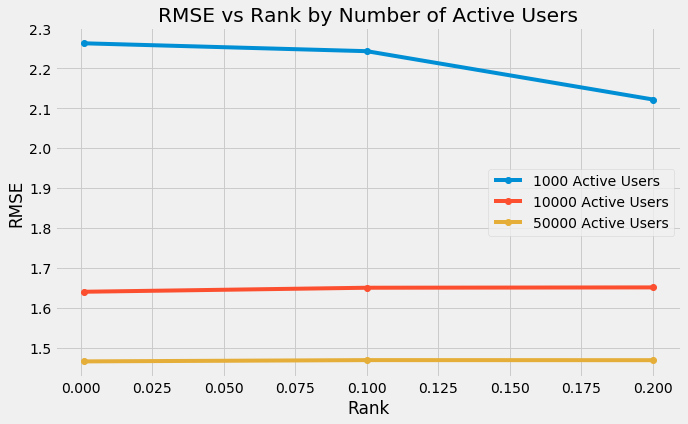

In [359]:
plot_rmse_vs_param(cv_ranks, reg_list, 'Rank')

In [360]:
best_rank = 20

In [372]:
# Final model
als = ALS(regParam=best_reg, rank=best_rank, maxIter=5, userCol="numeric_user_id", itemCol="numeric_business_id", ratingCol="rating",
          coldStartStrategy="drop", nonnegative= True)


final_models = []
for i in range(3):
    final_model = als.fit(all_sample_spark_dfs_train[i])
    final_models.append(final_model)

### 3.2.2 Accuracy of ALS Model  <a class="anchor" id="3-2-2"></a>

In [362]:
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

final_rmses = []
final_predictions_tests = []
for i in range(3):
    final_predictions_test = final_model.transform(all_sample_spark_dfs_test[i])
    final_predictions_tests.append(final_predictions_test)
    
    final_rmse = evaluator.evaluate(final_predictions_test)
    final_rmses.append(final_rmse)
    
    print('RMSEs (after tuning):', final_rmse)

RMSEs (after tuning): 1.600426918599562
RMSEs (after tuning): 1.8562133296184076
RMSEs (after tuning): 1.7165547226869933


In [363]:
baseline_MF_rmses = final_rmses

### 3.2.3 Coverage of ALS Model  <a class="anchor" id="3-2-3"></a>

In [386]:
als_catalog_coverages = []
for spark_test_df in final_predictions_tests:
    pandas_test_df = spark_test_df.toPandas()
    pandas_test_df.rename(columns={"numeric_user_id": "user_id", 'numeric_business_id': 'business_id'}, inplace=True)
    pandas_test_df.sort_values(by=['user_id', 'rating'])
    ratings_dictionary = dict(pandas_test_df.set_index('user_id').groupby(level = 0).apply(lambda x : x.to_dict(orient= 'records')))
    N = len(pandas_test_df['business_id'].unique())    
    als_catalog_coverages.append(calculate_catalog_coverage(ratings_dictionary, N, pred_col_name='prediction'))
    

Catalog Coverage: 57.14285714285714%
Catalog Coverage: 66.23971624217941%
Catalog Coverage: 71.20087601898041%


## 3.3 SVD++ <a class="anchor" id="3-3"></a>

## 3.4 Wide and Deep Model <a class="anchor" id="3-4"></a>

## 3.4.1 Feature Selection <a class="anchor" id="3-4-1"></a>

In [69]:
# take 20% of reviews for each user sampled
testing_data = active_user_only_ratings_df_sample.sort_values(by=['user_id', 'date']).groupby('user_id').apply(lambda x: x[round(len(x)*.8):]).reset_index(drop=True)

In [70]:
def create_features(active_user_only_ratings_df_sample):
    base_df = active_user_only_ratings_df_sample

    #sparse alert - hopefully with bigger dataset, we will see some weird ratings..
    real_average = base_df[['business_id','rating']].groupby('business_id').mean().reset_index()
    real_average.rename(columns={"rating": "average_business_rating"}, inplace=True)

    #Average ratings for business added
    base_df = base_df.merge(real_average, how='left', on='business_id')

    #one-hot encoding for top5 categories
    catList = []
    businesses['categories'].fillna(value='',inplace=True)
    businesses['cat'] = businesses['categories'].apply(lambda x: x.split(','))
    catList.extend(businesses['cat'])
    merged = [x.strip() for x in list(itertools.chain(*catList))]

    #Adding state, review_count, is_open
    base_df = base_df.merge(businesses[['business_id','state','city', 'latitude', 'longitude','review_count','is_open', 'hours', 'cat']], on='business_id')
    base_df.rename(columns={"review_count": "business_review_count"}, inplace=True)

    #getting top 5 common categories items
    top5List = [x for x in list(itertools.chain(*Counter(merged).most_common(5))) if type(x) != int]

    #one-hot encoding if the business in top 5 common category
    for item in top5List:
        base_df[item] = base_df['cat'].apply(lambda categories: 'Y' if bool(set([y.strip() for y in categories]).intersection([item])) else 'N')
        #base_df[item] = base_df['cat'].apply(lambda categories: 'Y' if bool(set([y.strip() for y in categories]).intersection(set(item))) else 'N')

    # is_open (categorical) change from 1 and 0 to Y and N
    base_df['is_open'] = base_df['is_open'].apply(lambda x: 'Y' if x else 'N')

    # hours: how many days per week it's open
    base_df['hours'] = base_df['hours'].apply(lambda x: len(x.keys()) if x else 0)
    base_df.rename(columns={"hours": "days_per_week_open"}, inplace=True)

    # user information
    base_df = base_df.merge(users[['user_id', 'average_stars', 'review_count', 'friends']],  on='user_id')

    # number_of_friends
    base_df['friends'] = base_df['friends'].apply(lambda x: len(x.split(',')))
    base_df.rename(columns={"friends": "number_of_friends", "review_count": "user_review_count", "average_stars": "average_user_rating"}, inplace=True)

    #number of tips for popularity measure of business
    business_numberOfTips = tips[['business_id','user_id']].groupby('business_id').count().reset_index()
    business_numberOfTips.rename(columns={"user_id": "business_numberOfTips"}, inplace=True)
    base_df = base_df.merge(business_numberOfTips, on='business_id')

    #number of photo for popularity measure of business
    business_numberOfPhotos = photos[['business_id','photo_id']].groupby('business_id').count().reset_index()
    business_numberOfPhotos.rename(columns={"photo_id": "business_numberOfPhotos"}, inplace=True)
    base_df = base_df.merge(business_numberOfPhotos, on='business_id')
    
    return base_df

In [75]:
training_features = create_features(training_data)
training_features.head()

,user_id,business_id,rating,date,average_business_rating,state,city,latitude,longitude,business_review_count,...,Restaurants,Shopping,Food,Home Services,Beauty & Spas,average_user_rating,user_review_count,number_of_friends,business_numberOfTips,business_numberOfPhotos
0,-3ur9azzCTt6loR3inuEtg,O_J5e6aoskxhGx8meOm1Og,5.0,2011-12-19 23:53:41,5.0,AZ,Gilbert,33.319178,-111.805840,136,...,Y,N,N,N,N,3.67,8,1,25,3
1,-rHPIHFPIaKxYYxqTsGcbQ,f-GwGqmGJ17F6w5CXcZkSg,4.0,2010-01-07 15:36:28,4.0,QC,Montréal,45.515998,-73.577519,212,...,Y,N,N,N,N,4.36,73,19,25,2
2,-rHPIHFPIaKxYYxqTsGcbQ,0W4lkclzZThpx3V65bVgig,4.0,2010-01-07 15:45:32,4.0,QC,Montréal,45.516353,-73.577642,2325,...,Y,N,Y,N,N,4.36,73,19,252,98
3,-rHPIHFPIaKxYYxqTsGcbQ,ewAmzOqnSAfLBdt4Stc8bA,2.0,2010-01-08 01:30:54,2.0,QC,Montréal,45.499532,-73.572196,91,...,Y,N,Y,N,N,4.36,73,19,27,12
4,-rHPIHFPIaKxYYxqTsGcbQ,EFOVNo26MCPe5dQC0HBifQ,3.0,2010-01-08 01:34:27,3.0,QC,Montreal,45.503064,-73.568461,42,...,Y,N,N,N,N,4.36,73,19,9,1


In [76]:
testing_features = create_features(testing_data)
testing_features.head()

,user_id,business_id,rating,date,average_business_rating,state,city,latitude,longitude,business_review_count,...,Restaurants,Shopping,Food,Home Services,Beauty & Spas,average_user_rating,user_review_count,number_of_friends,business_numberOfTips,business_numberOfPhotos
0,-rHPIHFPIaKxYYxqTsGcbQ,YI44-Pt98l03yaIeeKCuEQ,4.0,2012-10-10 20:42:39,4.0,QC,Montréal,45.475198,-73.580314,6,...,Y,N,N,N,N,4.36,73,19,2,1
1,-rHPIHFPIaKxYYxqTsGcbQ,Brgw8CWtNL6JxzTFxI0c7A,4.0,2012-11-18 17:27:03,4.0,QC,Montréal,45.474346,-73.587210,16,...,Y,N,Y,N,N,4.36,73,19,10,1
2,-rHPIHFPIaKxYYxqTsGcbQ,ZV7t55UEx1LnBOWqTrutSw,5.0,2013-05-12 15:22:14,5.0,QC,Montréal,45.480488,-73.579162,35,...,Y,N,N,N,N,4.36,73,19,2,5
3,-rHPIHFPIaKxYYxqTsGcbQ,ePXn4TX9DkfAeDK8VD5jLw,5.0,2013-05-18 18:58:16,5.0,QC,Montréal,45.474455,-73.623840,145,...,Y,N,N,N,N,4.36,73,19,34,2
4,1Wvkqv9J_Wqe-langvgT8Q,gv47gtyCkw_8OyexHrqdDA,2.0,2014-07-28 20:17:29,2.0,WI,Madison,43.075283,-89.386127,216,...,Y,N,N,N,N,2.89,6,1,15,8


In [220]:
training_features2 = create_features(training_data2)
testing_features2 = create_features(testing_data2)

In [221]:
training_features3 = create_features(training_data3)
testing_features3 = create_features(testing_data3)

## 3.4.2 Modeling <a class="anchor" id="3-4-2"></a>

## 3.4.3 Accuracy <a class="anchor" id="3-4-3"></a>

## 3.4.4 Coverage <a class="anchor" id="3-4-4"></a>

# 4. Evaluation <a class="anchor" id="4"></a>

## 4.1 Accuracy <a class="anchor" id="4-1"></a>

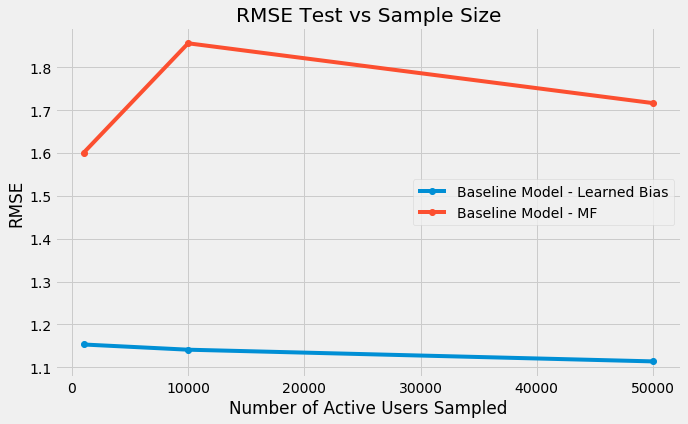

In [364]:
LEGEND = ['Baseline Model - Learned Bias', 'Baseline Model - MF', 'SVD++', 'Wide and Deep']

plt.figure(figsize=(10, 6))

plt.plot(sample_sizes, baseline_rmses, marker='o')
plt.plot(sample_sizes, baseline_MF_rmses, marker='o')
# plt.plot(sample_sizes, [min(rmse)  for rmse in knn_rmse_test], marker='o')
# plt.plot(sample_sizes, best_als_rmses, marker='o')

plt.xlabel('Number of Active Users Sampled')
plt.ylabel('RMSE')
plt.title('RMSE Test vs Sample Size')
plt.legend(LEGEND)
plt.grid(True)
plt.show()

## 4.2 Coverage <a class="anchor" id="4-2"></a>

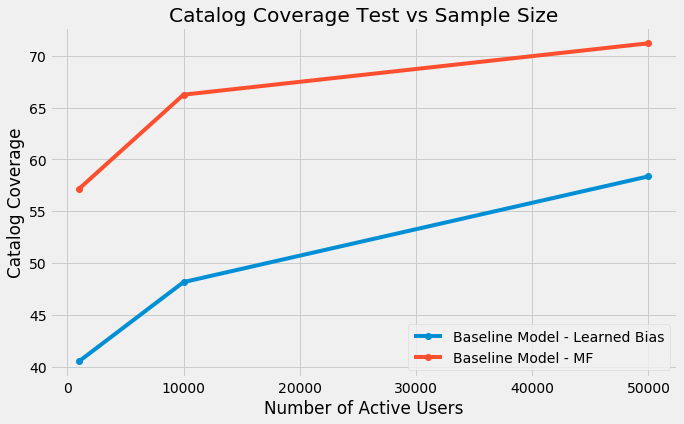

In [387]:
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, baseline_coverages, marker='o')
plt.plot(sample_sizes, als_catalog_coverages, marker='o')
# plt.plot(sample_sizes, knn_catalog_coverages, marker='o')
# plt.plot(sample_sizes, als_catalog_coverages, marker='o')

plt.xlabel('Number of Active Users')
plt.ylabel('Catalog Coverage')
plt.title('Catalog Coverage Test vs Sample Size')
plt.legend(LEGEND)
plt.grid(True)
plt.show()

# 5. Conclusion <a class="anchor" id="5"></a>